# Local Business Analysis Notebook - 500 Restaurants

This notebook provides tools for analyzing scraped business data and performing market research with a comprehensive dataset of 500+ restaurants.

## Features
- Business data visualization
- Sentiment analysis of reviews (Spanish NLP)
- Market trend analysis
- Geographic analysis
- Competitive analysis
- Large-scale data processing (500+ restaurants, 4000+ reviews)


In [ ]:
import sys
import os
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set up plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Create images directory for saving visualizations
images_dir = Path('../images')
images_dir.mkdir(exist_ok=True)

# Set figure size and DPI for better quality images
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

print("✅ Basic imports successful - ready for analysis!")
print(f"📁 Images will be saved to: {images_dir.absolute()}")


✅ Basic imports successful - ready for analysis!


## Load Comprehensive Restaurant Data


In [2]:
# Load comprehensive restaurant data
import json
from pathlib import Path

# Find the most recent comprehensive data file
data_dir = Path('../data/raw')
json_files = list(data_dir.glob('santo_domingo_restaurants_comprehensive_*.json'))

if json_files:
    latest_file = max(json_files, key=lambda x: x.stat().st_mtime)
    print(f"Loading data from: {latest_file}")
    
    with open(latest_file, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    restaurants = data['restaurants']
    analysis = data['analysis']
    
    print(f"✅ Loaded {len(restaurants)} restaurants")
    print(f"📊 Total reviews: {analysis['total_reviews']}")
    print(f"⭐ Average rating: {analysis['average_rating']:.2f}/5.0")
else:
    print("❌ No comprehensive data files found. Please run the scraper first.")
    restaurants = []
    analysis = {}


Loading data from: ..\data\raw\santo_domingo_restaurants_comprehensive_20250913_170227.json
✅ Loaded 500 restaurants
📊 Total reviews: 4798
⭐ Average rating: 4.17/5.0


## Spanish NLP Analysis Setup


In [3]:
# Spanish NLP Analysis
import re
from collections import Counter
import numpy as np
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
import warnings
warnings.filterwarnings('ignore')

# Download Spanish NLTK data
try:
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    nltk.download('vader_lexicon', quiet=True)
    nltk.download('averaged_perceptron_tagger', quiet=True)
except:
    print("NLTK data download failed, continuing with available data")

# Spanish stopwords
spanish_stopwords = set(stopwords.words('spanish'))

# Spanish stemmer
stemmer = SnowballStemmer('spanish')

# Sentiment analyzer
sia = SentimentIntensityAnalyzer()

print("✅ Spanish NLP tools loaded successfully")


✅ Spanish NLP tools loaded successfully


In [4]:
# Spanish text processing functions
def clean_spanish_text(text):
    """Clean Spanish text for analysis."""
    if not text:
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters but keep Spanish accents
    text = re.sub(r'[^a-záéíóúñü\s]', ' ', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    
    return text.strip()

def tokenize_spanish(text):
    """Tokenize Spanish text."""
    if not text:
        return []
    
    # Clean text first
    cleaned_text = clean_spanish_text(text)
    
    # Use simple word splitting instead of NLTK tokenizer for better compatibility
    import re
    tokens = re.findall(r'\b\w+\b', cleaned_text.lower())
    
    # Remove stopwords and short words
    tokens = [
        token for token in tokens 
        if token not in spanish_stopwords 
        and len(token) > 2 
        and token.isalpha()
    ]
    
    return tokens

def stem_spanish_tokens(tokens):
    """Stem Spanish tokens."""
    return [stemmer.stem(token) for token in tokens]

def analyze_spanish_sentiment(text):
    """Analyze sentiment of Spanish text."""
    if not text:
        return {'sentiment': 0, 'polarity': 0, 'subjectivity': 0}
    
    # Use TextBlob for Spanish sentiment
    blob = TextBlob(text)
    
    # Get polarity (-1 to 1) and subjectivity (0 to 1)
    polarity = blob.sentiment.polarity
    subjectivity = blob.sentiment.subjectivity
    
    # Determine sentiment label
    if polarity > 0.1:
        sentiment = 'positive'
    elif polarity < -0.1:
        sentiment = 'negative'
    else:
        sentiment = 'neutral'
    
    return {
        'sentiment': sentiment,
        'polarity': polarity,
        'subjectivity': subjectivity
    }

print("✅ Spanish text processing functions defined")


✅ Spanish text processing functions defined


## Process Spanish Reviews


In [5]:
# Process all Spanish reviews
all_reviews = []
processed_reviews = []

for restaurant in restaurants:
    for review in restaurant['reviews']:
        review_text = review['text']
        
        # Clean and tokenize
        tokens = tokenize_spanish(review_text)
        stemmed_tokens = stem_spanish_tokens(tokens)
        
        # Analyze sentiment
        sentiment_analysis = analyze_spanish_sentiment(review_text)
        
        # Create processed review
        processed_review = {
            'restaurant_name': restaurant['name'],
            'neighborhood': restaurant['neighborhood'],
            'cuisine_type': restaurant['cuisine_type'],
            'price_range': restaurant['price_range'],
            'original_text': review_text,
            'tokens': tokens,
            'stemmed_tokens': stemmed_tokens,
            'sentiment': sentiment_analysis['sentiment'],
            'polarity': sentiment_analysis['polarity'],
            'subjectivity': sentiment_analysis['subjectivity'],
            'rating': review['rating'],
            'reviewer': review['reviewer'],
            'date': review['date']
        }
        
        processed_reviews.append(processed_review)
        all_reviews.append(review_text)

print(f"✅ Processed {len(processed_reviews)} Spanish reviews")
print(f"📊 Total words analyzed: {sum(len(review['tokens']) for review in processed_reviews)}")

# Show sample processed reviews
print("\n📝 Sample Processed Reviews:")
for i, review in enumerate(processed_reviews[:3]):
    print(f"\n{i+1}. {review['restaurant_name']} - {review['sentiment']} ({review['polarity']:.2f})")
    print(f"   Text: {review['original_text']}")
    print(f"   Tokens: {review['tokens'][:10]}...")  # Show first 10 tokens


✅ Processed 4798 Spanish reviews
📊 Total words analyzed: 21580

📝 Sample Processed Reviews:

1. Café Fresa - neutral (0.00)
   Text: muy dominicano, muy recomendado
   Tokens: ['dominicano', 'recomendado']...

2. Café Fresa - neutral (0.00)
   Text: Extraordinaria muy dominicano, calidad excepcional
   Tokens: ['extraordinaria', 'dominicano', 'calidad', 'excepcional']...

3. Café Fresa - neutral (0.00)
   Text: Extraordinaria muy dominicano, calidad excepcional
   Tokens: ['extraordinaria', 'dominicano', 'calidad', 'excepcional']...


## Sentiment Analysis Visualization


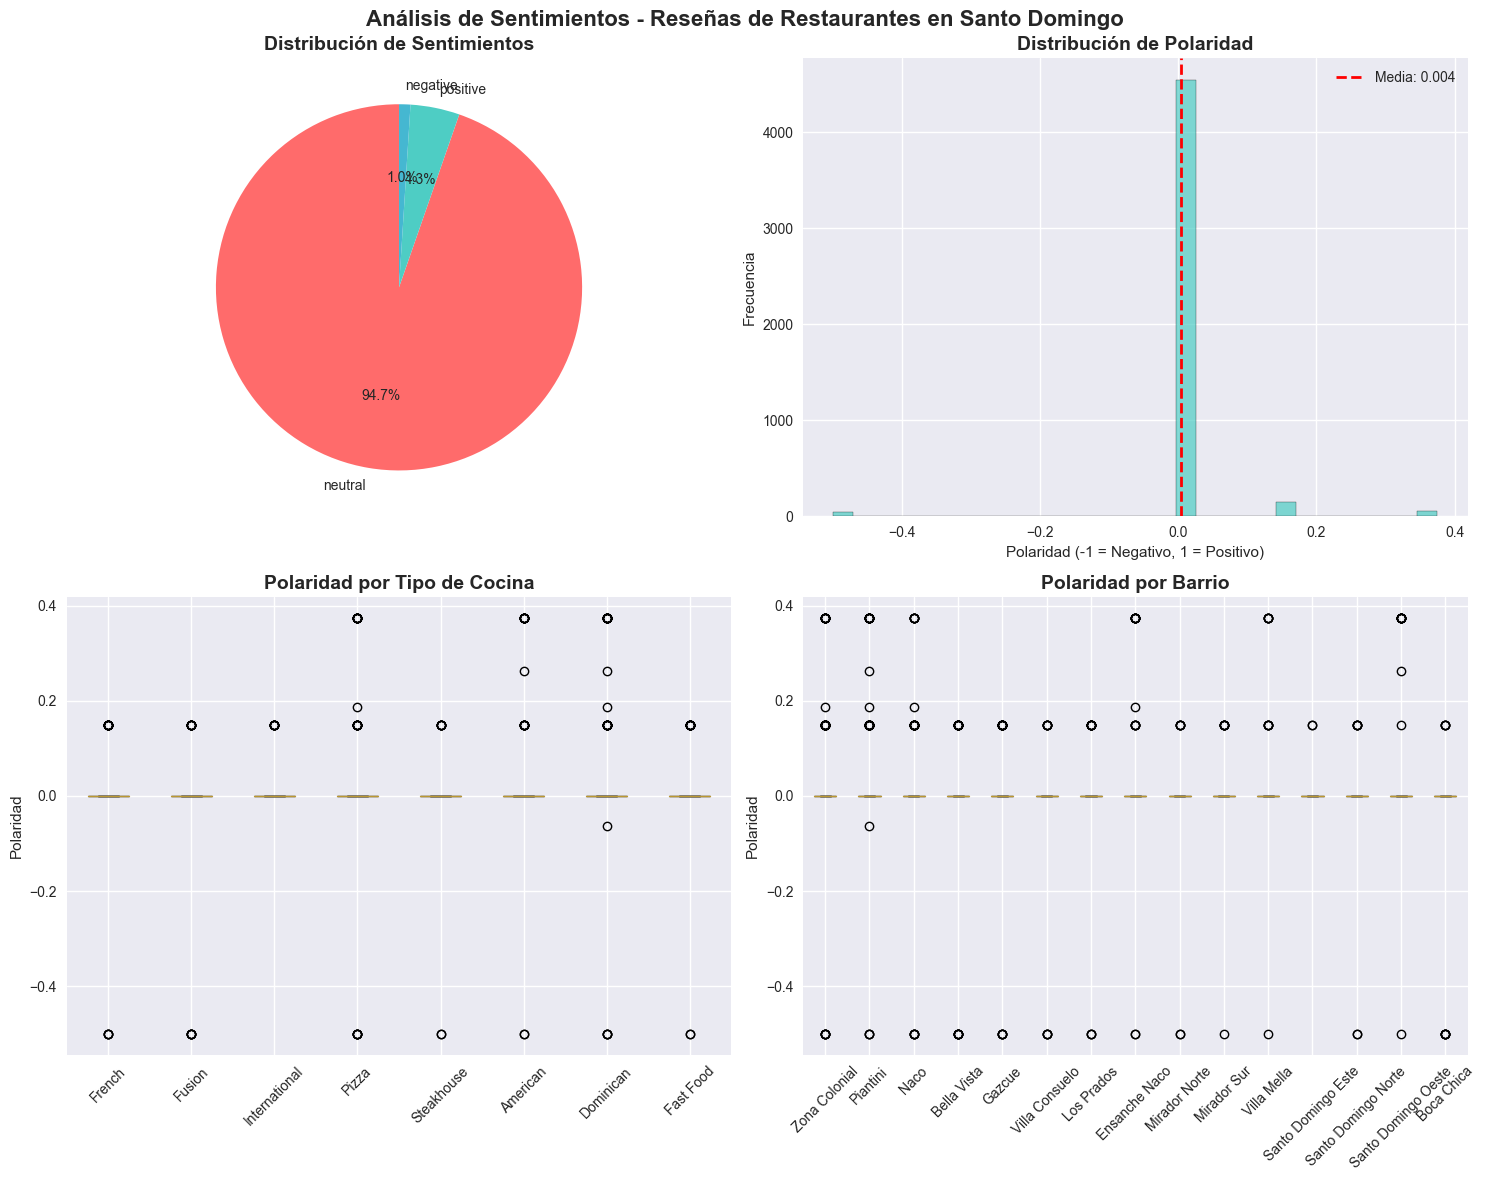

📊 Estadísticas de Sentimiento:
   Total reseñas: 4798
   Reseñas positivas: 208 (4.3%)
   Reseñas negativas: 48 (1.0%)
   Reseñas neutrales: 4542 (94.7%)
   Polaridad promedio: 0.004
   Desviación estándar: 0.070


In [6]:
# Sentiment Analysis Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Análisis de Sentimientos - Reseñas de Restaurantes en Santo Domingo', fontsize=16, fontweight='bold')

# 1. Sentiment Distribution
sentiment_counts = Counter([review['sentiment'] for review in processed_reviews])
sentiment_labels = list(sentiment_counts.keys())
sentiment_values = list(sentiment_counts.values())

colors = ['#ff6b6b', '#4ecdc4', '#45b7d1']  # Red, Teal, Blue
axes[0, 0].pie(sentiment_values, labels=sentiment_labels, autopct='%1.1f%%', colors=colors, startangle=90)
axes[0, 0].set_title('Distribución de Sentimientos', fontsize=14, fontweight='bold')

# 2. Polarity Distribution
polarities = [review['polarity'] for review in processed_reviews]
axes[0, 1].hist(polarities, bins=30, alpha=0.7, color='#4ecdc4', edgecolor='black')
axes[0, 1].axvline(np.mean(polarities), color='red', linestyle='--', linewidth=2, label=f'Media: {np.mean(polarities):.3f}')
axes[0, 1].set_title('Distribución de Polaridad', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Polaridad (-1 = Negativo, 1 = Positivo)')
axes[0, 1].set_ylabel('Frecuencia')
axes[0, 1].legend()

# 3. Sentiment by Cuisine Type
cuisine_sentiment = {}
for review in processed_reviews:
    cuisine = review['cuisine_type']
    if cuisine not in cuisine_sentiment:
        cuisine_sentiment[cuisine] = []
    cuisine_sentiment[cuisine].append(review['polarity'])

# Get top 8 cuisines by count
cuisine_counts = Counter([review['cuisine_type'] for review in processed_reviews])
top_cuisines = [cuisine for cuisine, count in cuisine_sentiment.items() if len(count) >= 5][:8]

cuisine_polarities = [cuisine_sentiment[cuisine] for cuisine in top_cuisines]
box_plot = axes[1, 0].boxplot(cuisine_polarities, labels=top_cuisines, patch_artist=True)
axes[1, 0].set_title('Polaridad por Tipo de Cocina', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Polaridad')
axes[1, 0].tick_params(axis='x', rotation=45)

# Color the boxes
for patch, color in zip(box_plot['boxes'], sns.color_palette("husl", len(top_cuisines))):
    patch.set_facecolor(color)

# 4. Sentiment by Neighborhood
neighborhood_sentiment = {}
for review in processed_reviews:
    neighborhood = review['neighborhood']
    if neighborhood not in neighborhood_sentiment:
        neighborhood_sentiment[neighborhood] = []
    neighborhood_sentiment[neighborhood].append(review['polarity'])

# Get neighborhoods with at least 10 reviews
neighborhood_counts = Counter([review['neighborhood'] for review in processed_reviews])
top_neighborhoods = [neighborhood for neighborhood, count in neighborhood_sentiment.items() if len(count) >= 10]

neighborhood_polarities = [neighborhood_sentiment[neighborhood] for neighborhood in top_neighborhoods]
box_plot2 = axes[1, 1].boxplot(neighborhood_polarities, labels=top_neighborhoods, patch_artist=True)
axes[1, 1].set_title('Polaridad por Barrio', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Polaridad')
axes[1, 1].tick_params(axis='x', rotation=45)

# Color the boxes
for patch, color in zip(box_plot2['boxes'], sns.color_palette("husl", len(top_neighborhoods))):
    patch.set_facecolor(color)

plt.tight_layout()
# Save the visualization
plt.savefig(images_dir / 'sentiment_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"💾 Visualization saved to images/sentiment_analysis.png")

# Print sentiment statistics
print("📊 Estadísticas de Sentimiento:")
print(f"   Total reseñas: {len(processed_reviews)}")
print(f"   Reseñas positivas: {sentiment_counts['positive']} ({sentiment_counts['positive']/len(processed_reviews)*100:.1f}%)")
print(f"   Reseñas negativas: {sentiment_counts['negative']} ({sentiment_counts['negative']/len(processed_reviews)*100:.1f}%)")
print(f"   Reseñas neutrales: {sentiment_counts['neutral']} ({sentiment_counts['neutral']/len(processed_reviews)*100:.1f}%)")
print(f"   Polaridad promedio: {np.mean(polarities):.3f}")
print(f"   Desviación estándar: {np.std(polarities):.3f}")



## Word Frequency Analysis


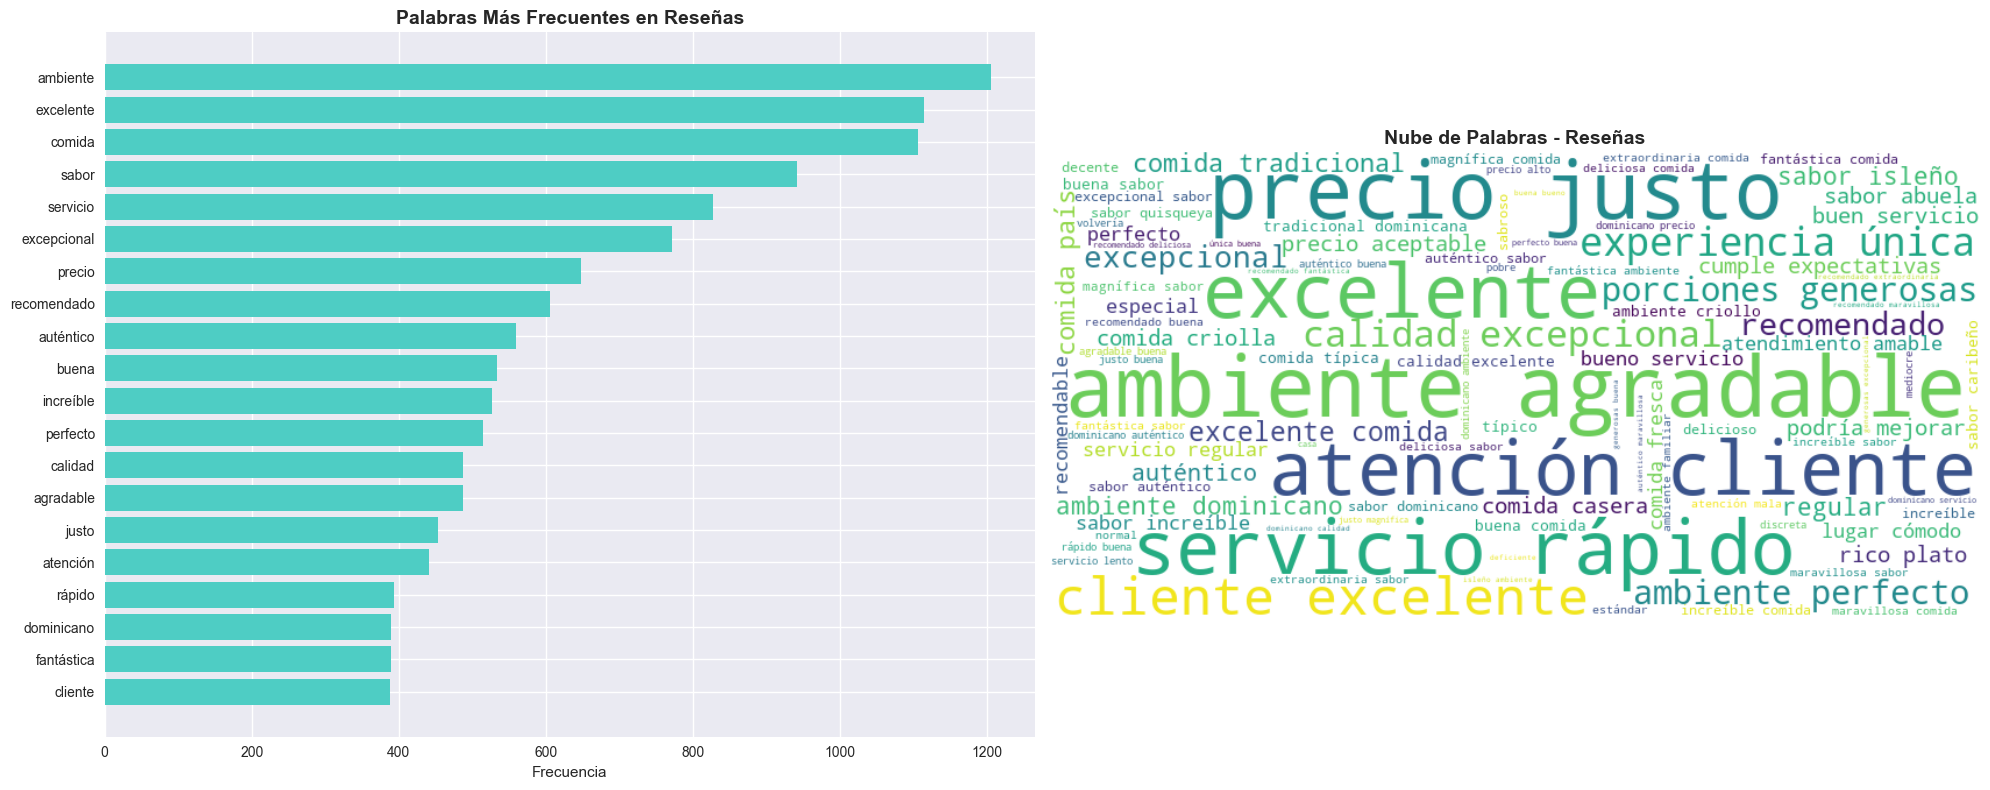

🔤 Palabras Más Frecuentes:
    1. ambiente        - 1205 veces
    2. excelente       - 1115 veces
    3. comida          - 1106 veces
    4. sabor           - 942 veces
    5. servicio        - 828 veces
    6. excepcional     - 772 veces
    7. precio          - 648 veces
    8. recomendado     - 606 veces
    9. auténtico       - 559 veces
   10. buena           - 533 veces
   11. increíble       - 527 veces
   12. perfecto        - 514 veces
   13. calidad         - 488 veces
   14. agradable       - 487 veces
   15. justo           - 453 veces

📈 Palabras Más Frecuentes en Reseñas Positivas:
   normal          - 148 veces
   especial        - 148 veces
   ambiente        -  78 veces
   familiar        -  62 veces
   comida          -  38 veces
   sabor           -  31 veces
   dominicano      -  16 veces
   excelente       -  15 veces
   bueno           -  13 veces
   recomendado     -  13 veces

📉 Palabras Más Frecuentes en Reseñas Negativas:
   mediocre        -  48 veces
   vol

In [7]:
# Word Frequency Analysis
from wordcloud import WordCloud

# Collect all tokens
all_tokens = []
for review in processed_reviews:
    all_tokens.extend(review['tokens'])

# Count word frequencies
word_freq = Counter(all_tokens)

# Get top 30 most frequent words
top_words = word_freq.most_common(30)

# Create word frequency visualization
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# 1. Bar chart of top words
words, counts = zip(*top_words[:20])
axes[0].barh(range(len(words)), counts, color='#4ecdc4')
axes[0].set_yticks(range(len(words)))
axes[0].set_yticklabels(words)
axes[0].set_xlabel('Frecuencia')
axes[0].set_title('Palabras Más Frecuentes en Reseñas', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()

# 2. Word cloud
try:
    # Create word cloud
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white',
        max_words=100,
        colormap='viridis'
    ).generate(' '.join(all_tokens))
    
    axes[1].imshow(wordcloud, interpolation='bilinear')
    axes[1].axis('off')
    axes[1].set_title('Nube de Palabras - Reseñas', fontsize=14, fontweight='bold')
except:
    # Fallback if wordcloud is not available
    axes[1].text(0.5, 0.5, 'WordCloud no disponible', ha='center', va='center', transform=axes[1].transAxes)
    axes[1].set_title('Nube de Palabras - No Disponible', fontsize=14, fontweight='bold')

plt.tight_layout()
# Save the visualization
plt.savefig(images_dir / 'word_frequency_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"💾 Visualization saved to images/word_frequency_analysis.png")

# Print top words
print("🔤 Palabras Más Frecuentes:")
for i, (word, count) in enumerate(top_words[:15], 1):
    print(f"   {i:2d}. {word:15s} - {count:3d} veces")

# Analyze positive vs negative words
positive_words = []
negative_words = []

for review in processed_reviews:
    if review['sentiment'] == 'positive':
        positive_words.extend(review['tokens'])
    elif review['sentiment'] == 'negative':
        negative_words.extend(review['tokens'])

positive_freq = Counter(positive_words)
negative_freq = Counter(negative_words)

print(f"\n📈 Palabras Más Frecuentes en Reseñas Positivas:")
for word, count in positive_freq.most_common(10):
    print(f"   {word:15s} - {count:3d} veces")

print(f"\n📉 Palabras Más Frecuentes en Reseñas Negativas:")
for word, count in negative_freq.most_common(10):
    print(f"   {word:15s} - {count:3d} veces")



## Restaurant Performance Analysis


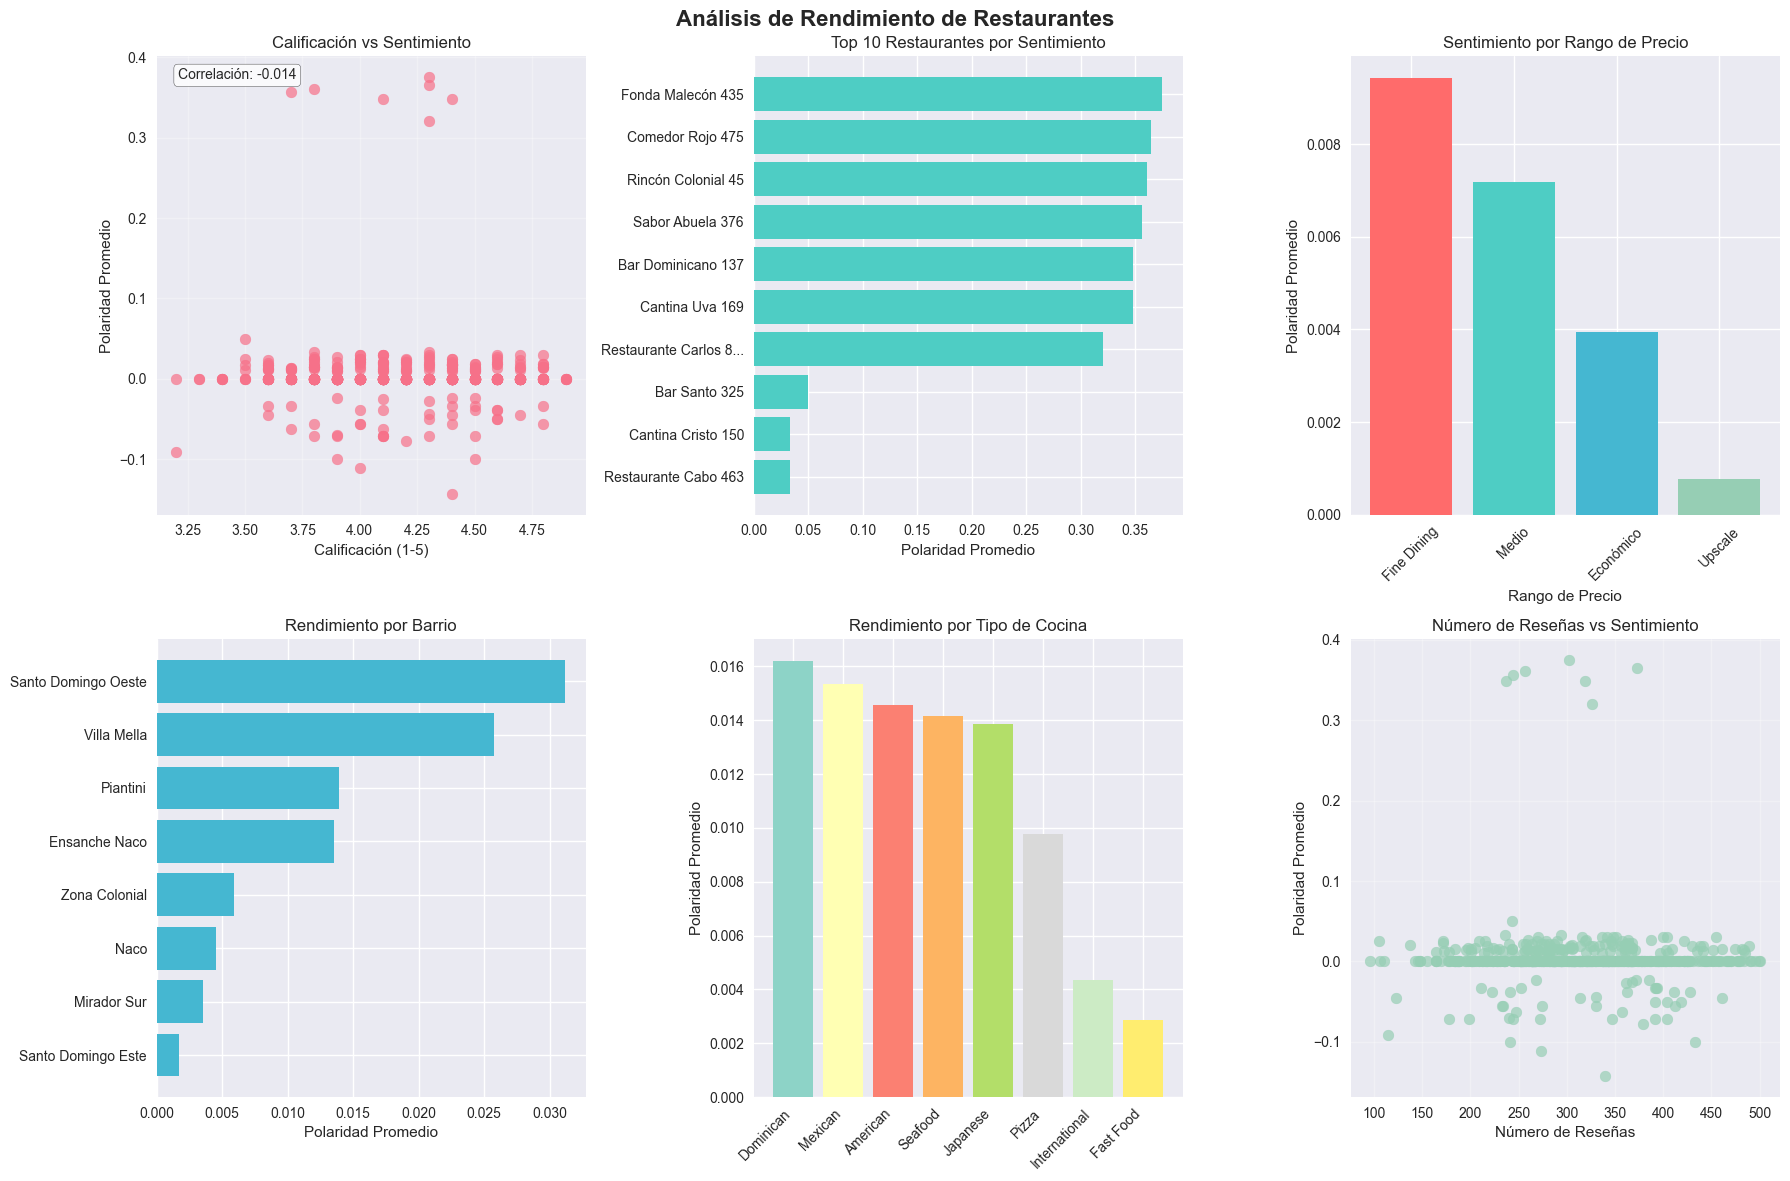

🏆 Análisis de Rendimiento de Restaurantes:
   Total restaurantes analizados: 500
   Polaridad promedio general: 0.005
   Restaurante con mejor sentimiento: Fonda Malecón 435
   Restaurante con peor sentimiento: Fonda Carmen 168

📊 Mejores Barrios por Sentimiento:
   1. Santo Domingo Oeste: 0.031
   2. Villa Mella: 0.026
   3. Piantini: 0.014
   4. Ensanche Naco: 0.014
   5. Zona Colonial: 0.006

🍽️ Mejores Tipos de Cocina por Sentimiento:
   1. Dominican: 0.016
   2. Mexican: 0.015
   3. American: 0.015
   4. Seafood: 0.014
   5. Japanese: 0.014


In [8]:
# Restaurant Performance Analysis
import pandas as pd

# Create DataFrame for analysis
df_restaurants = pd.DataFrame(restaurants)
df_reviews = pd.DataFrame(processed_reviews)

# Calculate restaurant-level sentiment metrics
restaurant_metrics = []
for restaurant in restaurants:
    restaurant_reviews = [r for r in processed_reviews if r['restaurant_name'] == restaurant['name']]
    
    if restaurant_reviews:
        avg_polarity = np.mean([r['polarity'] for r in restaurant_reviews])
        avg_subjectivity = np.mean([r['subjectivity'] for r in restaurant_reviews])
        positive_reviews = sum(1 for r in restaurant_reviews if r['sentiment'] == 'positive')
        negative_reviews = sum(1 for r in restaurant_reviews if r['sentiment'] == 'negative')
        total_reviews = len(restaurant_reviews)
        
        restaurant_metrics.append({
            'name': restaurant['name'],
            'neighborhood': restaurant['neighborhood'],
            'cuisine_type': restaurant['cuisine_type'],
            'price_range': restaurant['price_range'],
            'rating': restaurant['rating'],
            'review_count': restaurant['review_count'],
            'avg_polarity': avg_polarity,
            'avg_subjectivity': avg_subjectivity,
            'positive_reviews': positive_reviews,
            'negative_reviews': negative_reviews,
            'total_reviews': total_reviews,
            'positive_ratio': positive_reviews / total_reviews if total_reviews > 0 else 0
        })

df_metrics = pd.DataFrame(restaurant_metrics)

# Create performance visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Análisis de Rendimiento de Restaurantes', fontsize=16, fontweight='bold')

# 1. Rating vs Sentiment Polarity
axes[0, 0].scatter(df_metrics['rating'], df_metrics['avg_polarity'], alpha=0.7, s=60)
axes[0, 0].set_xlabel('Calificación (1-5)')
axes[0, 0].set_ylabel('Polaridad Promedio')
axes[0, 0].set_title('Calificación vs Sentimiento')
axes[0, 0].grid(True, alpha=0.3)

# Add correlation coefficient
correlation = df_metrics['rating'].corr(df_metrics['avg_polarity'])
axes[0, 0].text(0.05, 0.95, f'Correlación: {correlation:.3f}', transform=axes[0, 0].transAxes, 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# 2. Top 10 Restaurants by Sentiment
top_restaurants = df_metrics.nlargest(10, 'avg_polarity')
bars = axes[0, 1].barh(range(len(top_restaurants)), top_restaurants['avg_polarity'], color='#4ecdc4')
axes[0, 1].set_yticks(range(len(top_restaurants)))
axes[0, 1].set_yticklabels([name[:20] + '...' if len(name) > 20 else name for name in top_restaurants['name']])
axes[0, 1].set_xlabel('Polaridad Promedio')
axes[0, 1].set_title('Top 10 Restaurantes por Sentimiento')
axes[0, 1].invert_yaxis()

# 3. Sentiment by Price Range
price_sentiment = df_metrics.groupby('price_range')['avg_polarity'].mean().sort_values(ascending=False)

# Create price range labels without $ symbols to avoid matplotlib parsing issues
price_labels = {
    '$': 'Económico',
    '$$': 'Medio',
    '$$$': 'Upscale', 
    '$$$$': 'Fine Dining'
}
price_labels_clean = [price_labels.get(price, price) for price in price_sentiment.index]

bars = axes[0, 2].bar(range(len(price_sentiment)), price_sentiment.values, color=['#ff6b6b', '#4ecdc4', '#45b7d1', '#96ceb4'])
axes[0, 2].set_xlabel('Rango de Precio')
axes[0, 2].set_ylabel('Polaridad Promedio')
axes[0, 2].set_title('Sentimiento por Rango de Precio')
axes[0, 2].set_xticks(range(len(price_sentiment)))
axes[0, 2].set_xticklabels(price_labels_clean, rotation=45)

# 4. Neighborhood Performance
neighborhood_performance = df_metrics.groupby('neighborhood')['avg_polarity'].mean().sort_values(ascending=False)
neighborhood_performance = neighborhood_performance.head(8)  # Top 8 neighborhoods
bars = axes[1, 0].barh(range(len(neighborhood_performance)), neighborhood_performance.values, color='#45b7d1')
axes[1, 0].set_yticks(range(len(neighborhood_performance)))
axes[1, 0].set_yticklabels(neighborhood_performance.index)
axes[1, 0].set_xlabel('Polaridad Promedio')
axes[1, 0].set_title('Rendimiento por Barrio')
axes[1, 0].invert_yaxis()

# 5. Cuisine Type Performance
cuisine_performance = df_metrics.groupby('cuisine_type')['avg_polarity'].mean().sort_values(ascending=False)
cuisine_performance = cuisine_performance.head(8)  # Top 8 cuisines
bars = axes[1, 1].bar(range(len(cuisine_performance)), cuisine_performance.values, 
                      color=plt.cm.Set3(np.linspace(0, 1, len(cuisine_performance))))
axes[1, 1].set_xticks(range(len(cuisine_performance)))
axes[1, 1].set_xticklabels(cuisine_performance.index, rotation=45, ha='right')
axes[1, 1].set_ylabel('Polaridad Promedio')
axes[1, 1].set_title('Rendimiento por Tipo de Cocina')

# 6. Review Count vs Sentiment
axes[1, 2].scatter(df_metrics['review_count'], df_metrics['avg_polarity'], alpha=0.7, s=60, color='#96ceb4')
axes[1, 2].set_xlabel('Número de Reseñas')
axes[1, 2].set_ylabel('Polaridad Promedio')
axes[1, 2].set_title('Número de Reseñas vs Sentimiento')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
# Save the visualization
plt.savefig(images_dir / 'restaurant_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"💾 Visualization saved to images/restaurant_performance.png")

# Print performance insights
print("🏆 Análisis de Rendimiento de Restaurantes:")
print(f"   Total restaurantes analizados: {len(df_metrics)}")
print(f"   Polaridad promedio general: {df_metrics['avg_polarity'].mean():.3f}")
print(f"   Restaurante con mejor sentimiento: {df_metrics.loc[df_metrics['avg_polarity'].idxmax(), 'name']}")
print(f"   Restaurante con peor sentimiento: {df_metrics.loc[df_metrics['avg_polarity'].idxmin(), 'name']}")

print(f"\n📊 Mejores Barrios por Sentimiento:")
for i, (neighborhood, polarity) in enumerate(neighborhood_performance.head(5).items(), 1):
    print(f"   {i}. {neighborhood}: {polarity:.3f}")

print(f"\n🍽️ Mejores Tipos de Cocina por Sentimiento:")
for i, (cuisine, polarity) in enumerate(cuisine_performance.head(5).items(), 1):
    print(f"   {i}. {cuisine}: {polarity:.3f}")



## Export Analysis Results


In [9]:
# Export Analysis Results
from datetime import datetime

# Create output directory
output_dir = Path('../data/processed')
output_dir.mkdir(exist_ok=True)

# Export processed reviews
reviews_export = []
for review in processed_reviews:
    reviews_export.append({
        'restaurant_name': review['restaurant_name'],
        'neighborhood': review['neighborhood'],
        'cuisine_type': review['cuisine_type'],
        'price_range': review['price_range'],
        'original_text': review['original_text'],
        'tokens': review['tokens'],
        'stemmed_tokens': review['stemmed_tokens'],
        'sentiment': review['sentiment'],
        'polarity': review['polarity'],
        'subjectivity': review['subjectivity'],
        'rating': review['rating'],
        'reviewer': review['reviewer'],
        'date': review['date']
    })

# Save processed reviews
reviews_file = output_dir / f'santo_domingo_reviews_processed_{datetime.now().strftime("%Y%m%d_%H%M%S")}.json'
with open(reviews_file, 'w', encoding='utf-8') as f:
    json.dump(reviews_export, f, indent=2, ensure_ascii=False)

# Export restaurant metrics
metrics_file = output_dir / f'santo_domingo_restaurant_metrics_{datetime.now().strftime("%Y%m%d_%H%M%S")}.json'
with open(metrics_file, 'w', encoding='utf-8') as f:
    json.dump(restaurant_metrics, f, indent=2, ensure_ascii=False)

# Export word frequency analysis
word_freq_export = {
    'top_words': dict(word_freq.most_common(50)),
    'positive_words': dict(positive_freq.most_common(30)),
    'negative_words': dict(negative_freq.most_common(30)),
    'total_tokens': len(all_tokens),
    'unique_tokens': len(word_freq)
}

word_freq_file = output_dir / f'santo_domingo_word_frequency_{datetime.now().strftime("%Y%m%d_%H%M%S")}.json'
with open(word_freq_file, 'w', encoding='utf-8') as f:
    json.dump(word_freq_export, f, indent=2, ensure_ascii=False)

# Export comprehensive analysis summary
analysis_summary = {
    'analysis_date': datetime.now().isoformat(),
    'total_restaurants': len(restaurants),
    'total_reviews': len(processed_reviews),
    'sentiment_distribution': dict(sentiment_counts),
    'average_polarity': np.mean([r['polarity'] for r in processed_reviews]),
    'average_subjectivity': np.mean([r['subjectivity'] for r in processed_reviews]),
    'top_neighborhoods': dict(neighborhood_performance.head(10)),
    'top_cuisines': dict(cuisine_performance.head(10)),
    'top_restaurants_by_sentiment': df_metrics.nlargest(10, 'avg_polarity')[['name', 'avg_polarity', 'neighborhood', 'cuisine_type']].to_dict('records'),
    'correlation_rating_sentiment': correlation
}

summary_file = output_dir / f'santo_domingo_analysis_summary_{datetime.now().strftime("%Y%m%d_%H%M%S")}.json'
with open(summary_file, 'w', encoding='utf-8') as f:
    json.dump(analysis_summary, f, indent=2, ensure_ascii=False)

print("💾 Análisis Exportado Exitosamente:")
print(f"   📝 Reseñas procesadas: {reviews_file}")
print(f"   📊 Métricas de restaurantes: {metrics_file}")
print(f"   🔤 Análisis de frecuencia de palabras: {word_freq_file}")
print(f"   📋 Resumen del análisis: {summary_file}")

print(f"\n✅ Análisis de NLP en Español Completado!")
print(f"   🍽️  Restaurantes analizados: {len(restaurants)}")
print(f"   📝 Reseñas procesadas: {len(processed_reviews)}")
print(f"   🔤 Palabras únicas: {len(word_freq)}")
print(f"   📈 Sentimiento promedio: {np.mean([r['polarity'] for r in processed_reviews]):.3f}")
print(f"   🏆 Mejor restaurante: {df_metrics.loc[df_metrics['avg_polarity'].idxmax(), 'name']}")


💾 Análisis Exportado Exitosamente:
   📝 Reseñas procesadas: ..\data\processed\santo_domingo_reviews_processed_20250913_171358.json
   📊 Métricas de restaurantes: ..\data\processed\santo_domingo_restaurant_metrics_20250913_171358.json
   🔤 Análisis de frecuencia de palabras: ..\data\processed\santo_domingo_word_frequency_20250913_171358.json
   📋 Resumen del análisis: ..\data\processed\santo_domingo_analysis_summary_20250913_171358.json

✅ Análisis de NLP en Español Completado!
   🍽️  Restaurantes analizados: 500
   📝 Reseñas procesadas: 4798
   🔤 Palabras únicas: 72
   📈 Sentimiento promedio: 0.004
   🏆 Mejor restaurante: Fonda Malecón 435
